In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Normalization, BatchNormalization, Dropout, LeakyReLU, ELU, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB3, efficientnet_v2
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC

dataset_folder = "/content/drive/MyDrive/Agricultural-crops"

image_paths = []
labels = []
classes = os.listdir(dataset_folder)
n_classes = len(classes)
for c in classes:
    class_folder = dataset_folder + "/" + c
    for image in os.listdir(class_folder):
        image_path = class_folder + "/" + image
        image_paths.append(image_path)
        labels.append(c)

df = pd.DataFrame({"image_path": image_paths, "label": labels})

train_df, val_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=666)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    shear_range=0.1,
    channel_shift_range=0.1
)

ts = 224 ; # 384


train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="image_path",
    y_col="label",
    target_size=(ts, ts),
    class_mode="categorical",
    shuffle=False
)
tf.test.is_gpu_available()

Found 580 validated image filenames belonging to 30 classes.
Found 249 validated image filenames belonging to 30 classes.


False

In [ ]:
import matplotlib.pyplot as plt
import time



base_model = keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(ts, ts, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=n_classes,
    pooling=None,
)


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(n_classes, activation="softmax")
])


optimizer = optimizers.RMSprop(learning_rate=0.0008 )


model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1.0e-15)
checkpoint = ModelCheckpoint('model{"val_loss":.2f}.h5', monitor=model.compiled_metrics, verbose=0, save_best_only=True, mode='max')
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.005, decay_rate=0.5, decay_steps=1, staircase=True)
e = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

inicio = time.time()


history = model.fit(
    train_generator,
    epochs=20,
    batch_size=4,
    validation_data=val_generator,
    callbacks=[early_stopping]
)
# Grava o tempo final
fim = time.time()

# Calcula o tempo total decorrido
tempo_total = fim - inicio
print(f"Tempo de execução: {tempo_total} segundos")








Epoch 1/20
19/19 [==============================] - 47s 2s/step - loss: 4.2232 - accuracy: 0.0448 - val_loss: 3.2912 - val_accuracy: 0.0843
Epoch 2/20
19/19 [==============================] - 32s 2s/step - loss: 3.9292 - accuracy: 0.0638 - val_loss: 3.1681 - val_accuracy: 0.0964
Epoch 3/20
19/19 [==============================] - 30s 2s/step - loss: 3.7692 - accuracy: 0.0741 - val_loss: 3.1240 - val_accuracy: 0.1285
Epoch 4/20
19/19 [==============================] - 31s 2s/step - loss: 3.6846 - accuracy: 0.0828 - val_loss: 3.0389 - val_accuracy: 0.1647
Epoch 5/20
19/19 [==============================] - 31s 2s/step - loss: 3.4366 - accuracy: 0.1121 - val_loss: 3.0299 - val_accuracy: 0.1205
Epoch 6/20
19/19 [==============================] - 30s 2s/step - loss: 3.3595 - accuracy: 0.1259 - val_loss: 2.9502 - val_accuracy: 0.1727
Epoch 7/20
19/19 [==============================] - 31s 2s/step - loss: 3.2258 - accuracy: 0.1603 - val_loss: 2.9093 - val_accuracy: 0.1647
Epoch 8/20
19/19 [==

Train AUC: 2.66
Validation AUC: 2.69


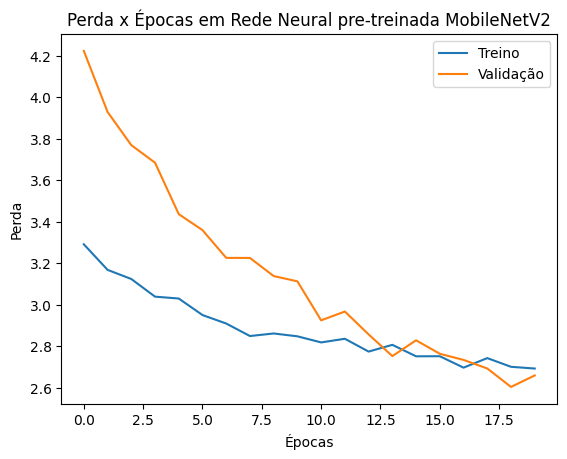

In [ ]:
# Print the train and eval metrics
print('Train AUC: {:.2f}'.format(history.history['loss'][-1]))
print('Validation AUC: {:.2f}'.format(history.history['val_loss'][-1]))


print(history)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Perda x Épocas em Rede Neural pre-treinada MobileNetV2')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.savefig('plot_salvato.png')
plt.show()

Key: loss, Value: [4.22323751449585, 3.9291558265686035, 3.769176721572876, 3.6846187114715576, 3.4365906715393066, 3.3595468997955322, 3.225799083709717, 3.225346326828003, 3.138124942779541, 3.1126320362091064, 2.9246740341186523, 2.9671847820281982, 2.8569154739379883, 2.752393960952759, 2.8284666538238525, 2.763509511947632, 2.7340424060821533, 2.6926565170288086, 2.603778600692749, 2.659090757369995]
Key: accuracy, Value: [0.04482758790254593, 0.06379310041666031, 0.07413793355226517, 0.08275862038135529, 0.11206896603107452, 0.12586206197738647, 0.16034482419490814, 0.14482758939266205, 0.158620685338974, 0.15172414481639862, 0.20344828069210052, 0.17931035161018372, 0.2224137932062149, 0.23965516686439514, 0.22068965435028076, 0.22758620977401733, 0.21896551549434662, 0.23965516686439514, 0.2655172348022461, 0.22758620977401733]
Key: val_loss, Value: [3.291159152984619, 3.168060064315796, 3.123962640762329, 3.038870096206665, 3.0298948287963867, 2.9502127170562744, 2.90931391716

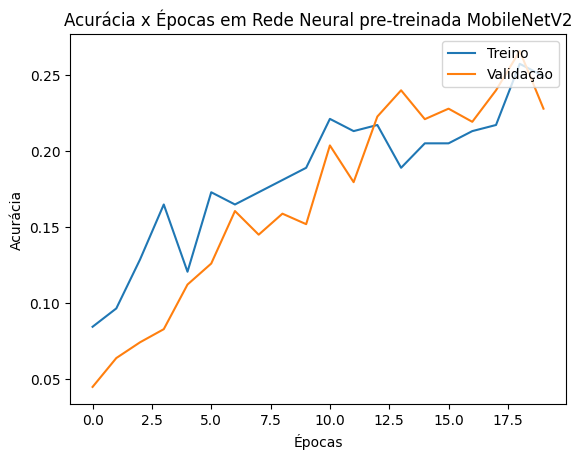

In [ ]:
for key, value in (history.history.items()):
    print(f'Key: {key}, Value: {value}')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Acurácia x Épocas em Rede Neural pre-treinada MobileNetV2')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()